# Setup

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
sns.set()
from tensorflow.keras import layers
from sklearn import preprocessing, model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

/home/sigis/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [15]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)

#Load all data
data = pd.read_csv('data/all_annotations.tsv', sep='\t')

#Split it into labels and features
y = data[['chord']]
tx = data.drop(columns='chord')

#Use one-hot encoding/dummy variabes for categorical values
y = pd.get_dummies(y)
tx = pd.get_dummies(tx)

#Replace Nans with zero, since x*nan = nan
tx = tx.replace(np.nan, 0)

#Standardize it? 
tx = (tx-tx.mean())/tx.std()

#Split the data into training and test sets
#Since order is important, shuffle = False, but we should probably split on the moments or something similar
train_x, test_x, train_y, test_y = model_selection.train_test_split(tx, y, test_size = 0.1, shuffle = False)

# Data exploration

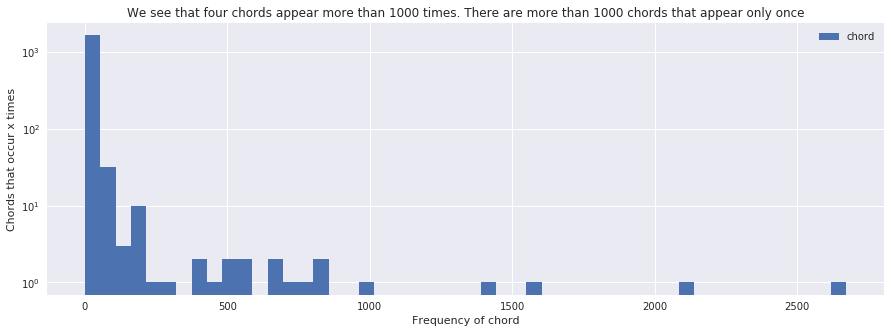

In [16]:
#Count how many times each chord appear
chord_dist = data[['chord']].groupby('chord')['chord'].count()

#Sort them and make them into a dataframe
chord_dist = chord_dist.sort_values(ascending = False)
chord_dist = pd.DataFrame(chord_dist)

#Plot the distribution
ax = chord_dist.plot.hist(bins= 50, figsize = [15,5])
ax.semilogy()
ax.set_xlabel("Frequency of chord")
ax.set_ylabel("Chords that occur x times")
_=ax.set_title("We see that four chords appear more than 1000 times. There are more than 1000 chords that appear only once")


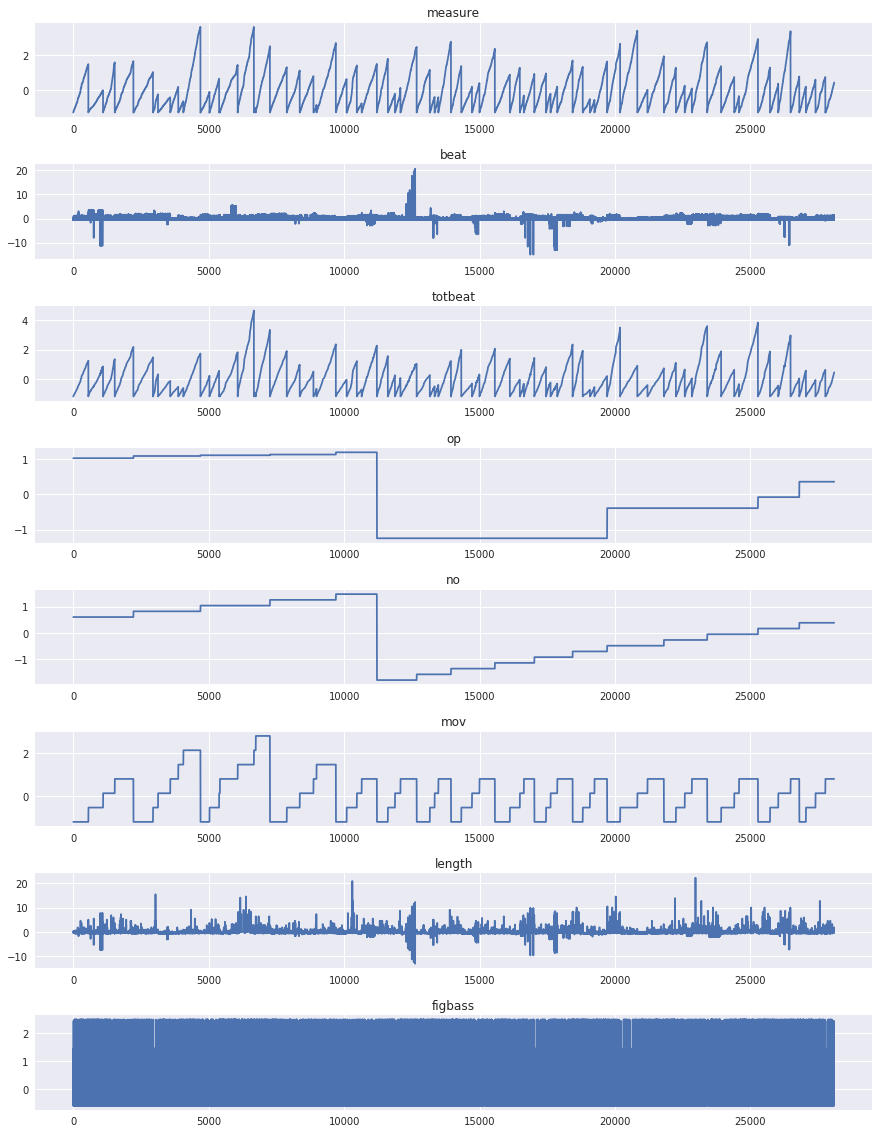

In [17]:
#Let's see if the features have any patterns
to_inspect = ['measure', 'beat', 'totbeat', 'op', 'no', 'mov', 'length',
       'figbass']

#Plot all data for each feature in a subplot
f, axes = plt.subplots(len(to_inspect), 1)
plt.subplots_adjust(hspace = 0.5)
for i,  feature in enumerate(to_inspect):
    tx[feature].plot(ax = axes[i], figsize = [15,20])
    axes[i].set_title(feature)

# Models

In [18]:
def sequential(classes, features, optimizer, loss, metrics):
    """
    A sequential neural network. You train on features until you learn to predict a chord from its corresponding features.
    The kind of model we would have used if we wanted to predict to do chord classification.
    Just for testing purposes.
    """
    #Setup basic model
    model = tf.keras.Sequential()
    
    # Input layer. One node for each feature
    model.add(layers.Dense(32, input_dim = features, activation='relu'))
    
    # Hidden layer
    model.add(layers.Dense(16, activation='relu'))

    # Output layer. One node for each class
    model.add(layers.Dense(classes, activation='softmax'))

    #Compile the model with the chosen parameters
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics= metrics)
    return model

In [6]:
def lstm():
    """
    A network with memory. Deals with predicting the next step in a sequence
    """

# Train

In [19]:
#Model parameters
classes = y.shape[1]
features = tx.shape[1]
optimizer = tf.train.AdamOptimizer(0.001)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

#Generate model
model = sequential(classes, features, optimizer, loss, metrics)

#Train on it and save metrics at each epoch
history = model.fit(train_x,
                    train_y,
                    epochs = 20,
                    batch_size = 1000,
                    verbose = 1,
                    validation_split = 0.1)

Train on 22756 samples, validate on 2529 samples
Epoch 1/20
22756/22756 [==============================] - 7s 298us/step - loss: 7.3691 - acc: 0.0185 - val_loss: 7.2634 - val_acc: 0.0308
Epoch 2/20
22756/22756 [==============================] - 6s 279us/step - loss: 6.9261 - acc: 0.0475 - val_loss: 6.7741 - val_acc: 0.0672
Epoch 3/20
22756/22756 [==============================] - 6s 279us/step - loss: 5.8223 - acc: 0.0756 - val_loss: 5.8020 - val_acc: 0.0838
Epoch 4/20
22756/22756 [==============================] - 7s 303us/step - loss: 4.5823 - acc: 0.0900 - val_loss: 4.9133 - val_acc: 0.0807
Epoch 5/20
22756/22756 [==============================] - 9s 385us/step - loss: 4.1420 - acc: 0.1025 - val_loss: 4.5096 - val_acc: 0.1079
Epoch 6/20
22756/22756 [==============================] - 8s 372us/step - loss: 3.8426 - acc: 0.1568 - val_loss: 4.1581 - val_acc: 0.1665
Epoch 7/20
22756/22756 [==============================] - 7s 312us/step - loss: 3.5220 - acc: 0.2233 - val_loss: 3.8150 - v

# Results

Loss on test set = 4.113489138274006
Accuracy on test set = 0.341281139044575


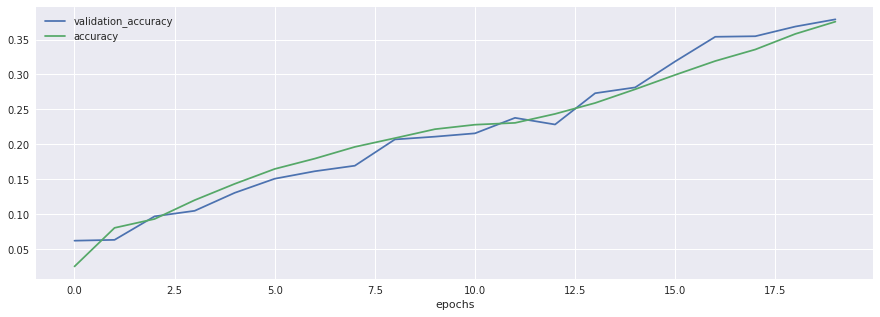

In [8]:
#Save the history of the learning into a dataframe
df = pd.DataFrame({'epochs': history.epoch,
                   'accuracy': history.history['acc'],
                   'validation_accuracy': history.history['val_acc'],
                   'loss': history.history['loss']})


#Plot the the scores on the validation and training sets
df.plot(x='epochs', y = ['validation_accuracy','accuracy'], figsize=[15,5])

#Get the scores on the test set
scores = model.evaluate(test_x, test_y, verbose=0)
print("Loss on test set = {}\nAccuracy on test set = {}".format(scores[0], scores[1]))